# Variational PINN (VPINN) Example for 1D Poisson Equation

This notebook implements a Variational Physics-Informed Neural Network (VPINN) to solve a 1D Poisson equation. Unlike standard PINNs that minimize the strong-form (point-wise) PDE residual, VPINNs are based on the **weak form** of the equation, which is derived from the calculus of variations.

### Core Idea of VPINN

1.  **Weak Formulation:** The strong-form PDE is multiplied by a "test function" `v(x)` and integrated over the domain. Through integration by parts, derivatives are "transferred" from the solution `u(x)` to the test function `v(x)`. This reduces the order of derivatives required from the neural network, leading to a smoother loss landscape and more stable training, especially for high-order PDEs.
2.  **Custom Residual:** The loss is not the point-wise PDE error, but the error in satisfying the integral equations for a chosen set of test functions.
3.  **Numerical Integration:** The integrals are approximated numerically. In this example, we use **Monte Carlo integration** by taking the mean of the integrand values over a large batch of random collocation points in the domain.

### Problem Definition

- **PDE (Strong Form):** 
  $$ -u_{xx}(x) = \pi^2 \sin(\pi x) $$
- **Domain:** $x \in [-1, 1]$
- **Boundary Conditions (BCs):** $u(-1) = 0$, $u(1) = 0$
- **Analytical Solution:** $u(x) = \sin(\pi x)$



In [2]:
import deepxde as dde
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("whitegrid")


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


### Step 1: Define Geometry, BC, and Analytical Solution

We begin by setting up the standard components of the problem.
- **Geometry:** A simple 1D interval from -1 to 1.
- **Boundary Conditions:** Standard Dirichlet BCs, setting `u=0` at both ends.
- **Analytical Solution:** We define the true solution `u(x) = sin(πx)` which will be used to calculate the L2 relative error after training.


In [3]:
# 1. Define Geometry
geom = dde.geometry.Interval(-1, 1)

# 2. Define Boundary Conditions
def boundary_func(_, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geom, lambda x: 0, boundary_func)

# 3. Define the Analytical Solution (for comparison)
# This function is robust to handle both NumPy arrays and backend Tensors.
def analytical_solution(x):
    if isinstance(x, np.ndarray):
        sin = np.sin
        pi = np.pi
    else:
        sin = dde.backend.sin
        pi = dde.backend.pi
    return sin(pi * x)


### Step 2: Define VPINN Components

This is the core of the VPINN implementation. We need to define the components necessary to construct the weak form of the PDE.

The weak form for $-u_{xx} = f$ is found by multiplying by a test function $v$ and integrating by parts:
$$ -\int_{-1}^{1} u_{xx} v \,dx = \int_{-1}^{1} f v \,dx $$
$$ \left[-u_x v\right]_{-1}^{1} + \int_{-1}^{1} u_x v_x \,dx = \int_{-1}^{1} f v \,dx $$
If we choose test functions $v$ such that $v(-1) = v(1) = 0$, the boundary term vanishes, leaving us with the weak form:
$$ \int_{-1}^{1} (u_x v_x - f v) \,dx = 0 $$
This integral must hold for *all* chosen test functions $v$.

- **Source Function `f(x)`:** We define the function on the right-hand side of the PDE.
- **Test Functions `v(x)`:** We choose a set of simple basis functions that are zero at the boundaries, satisfying the condition for the weak form. Here, we use two polynomial functions. We also need their analytical derivatives, `v'(x)`.
- **VPINN Residual `pde_vpinn`:** This is a custom function that computes the loss. For each test function `v`, it calculates the integrand $(u_x v_x - f v)$ and approximates the integral by taking the mean over the batch of collocation points. The final PDE loss is the sum of the squared integral residuals from all test functions.



In [4]:
# 4.1 Source function f(x) for the PDE
def pde_source_func(x):
    return torch.pi**2 * torch.sin(torch.pi * x)

# 4.2 Define a set of test functions v(x) and their derivatives v'(x)
# Test functions should be zero at the boundary to satisfy Dirichlet conditions.
def v_0(x):
    return 1 - x**2
def v_0_x(x):
    return -2 * x

def v_1(x):
    return x * (1 - x**2)
def v_1_x(x):
    return 1 - 3 * x**2

test_functions = [(v_0, v_0_x), (v_1, v_1_x)]

# 4.3 Define the VPINN residual function (weak form)
def pde_vpinn(x, u):
    # u is the network output, shape: (batch_size, 1)
    # x is the network input, shape: (batch_size, 1)
    
    # Get derivatives of the network output u with respect to input x
    u_x = dde.grad.jacobian(u, x, i=0, j=0)
    
    # Get source function values for the input points
    f_val = pde_source_func(x)
    
    # Calculate the residual for each test function
    residuals = []
    for v, v_x in test_functions:
        v_val = v(x)
        v_x_val = v_x(x)
        
        # Weak form for -u_xx = f  is  Integral(u_x * v_x - f * v)dx = 0
        integrand = u_x * v_x_val - f_val * v_val
        
        # Approximate the integral over the domain by taking the mean over the batch.
        # This is a Monte Carlo integration.
        integral_residual = torch.mean(integrand)
        residuals.append(integral_residual)

    # The final PDE loss is the sum of the squared residuals from all test functions.
    # We return the same scalar loss value for each point in the batch.
    return torch.sum(torch.stack(residuals)**2) * torch.ones_like(u)


### Step 3: Assemble, Train, and Visualize

Finally, we assemble the `dde.data.PDE` object, define the network, and train the model.

- **Data Object:** We pass our custom `pde_vpinn` function as the PDE residual. A key difference for VPINNs using Monte Carlo integration is that we need a larger number of domain points (`num_domain`) to get a stable and accurate approximation of the integrals.
- **Network and Training:** The network architecture and training process are standard. We compile with the Adam optimizer and train for a set number of iterations.
- **Visualization:** After training, we plot the loss history to check for convergence. We then compare the VPINN's predicted solution against the analytical solution to visually assess its accuracy and compute the final L2 relative error.



In [6]:
# 5. Define the Data object for the VPINN
# We need a large number of domain points for the Monte Carlo integration.
data = dde.data.PDE(
    geom,
    pde_vpinn,
    bc,
    num_domain=500,  # More points for better integral approximation
    num_boundary=2,
    solution=analytical_solution,
    num_test=100,
)

# 6. Define the Neural Network
net = dde.nn.FNN([1] + [20] * 3 + [1], "tanh", "Glorot normal")

# 7. Compile and Train the Model
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=15000)




Compiling model...
'compile' took 13.027152 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.43e+01, 7.64e-04]    [1.40e+01, 7.64e-04]    [1.00e+00]    


c:\Users\SUNNIE.GD.WENG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [3.18e-05, 7.25e-08]    [6.98e-06, 7.25e-08]    [2.24e-01]    
2000      [2.42e-06, 1.50e-09]    [7.95e-08, 1.50e-09]    [2.32e-01]    
3000      [4.51e-07, 1.20e-10]    [4.07e-09, 1.24e-10]    [2.35e-01]    
4000      [1.16e-07, 1.79e-11]    [1.05e-08, 1.67e-11]    [2.37e-01]    
5000      [3.49e-08, 1.38e-10]    [3.51e-08, 1.37e-10]    [2.38e-01]    
6000      [1.16e-08, 2.26e-09]    [7.44e-08, 2.24e-09]    [2.39e-01]    
7000      [4.24e-09, 3.51e-11]    [1.20e-07, 3.55e-11]    [2.39e-01]    
8000      [3.20e-09, 2.09e-09]    [1.37e-07, 2.07e-09]    [2.40e-01]    
9000      [5.78e-09, 4.03e-09]    [1.08e-07, 4.02e-09]    [2.40e-01]    
10000     [5.58e-09, 6.77e-09]    [1.06e-07, 6.77e-09]    [2.41e-01]    
11000     [4.95e-09, 1.78e-15]    [1.09e-07, 4.00e-15]    [2.43e-01]    
12000     [6.02e-09, 1.76e-13]    [9.95e-08, 7.48e-14]    [2.45e-01]    
13000     [9.60e-09, 1.34e-05]    [8.62e-08, 1.34e-05]    [2.48e-01]    
14000     [4.65e-09, 1.17e-07]    [1.13e-07, 1.17e-

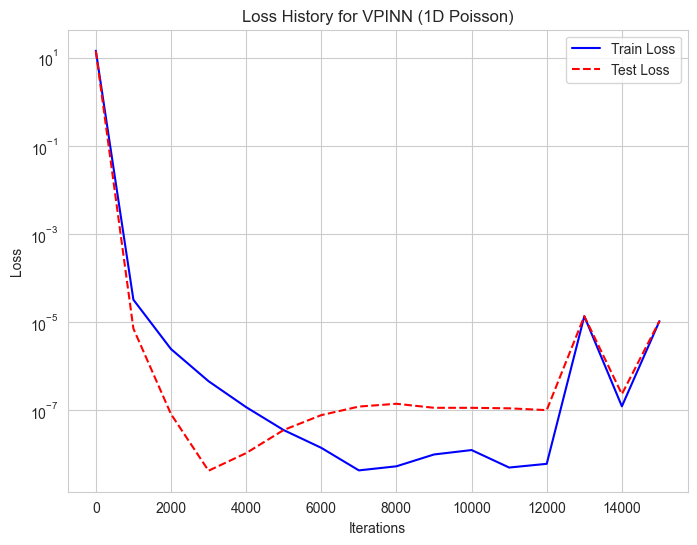

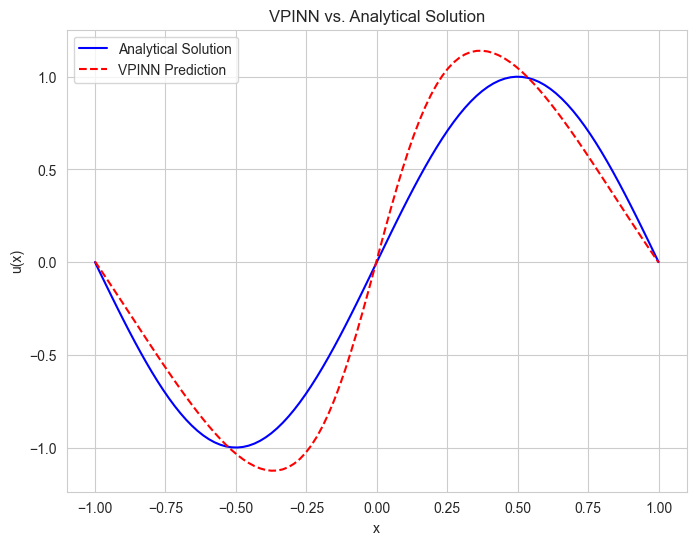

L2 relative error: 2.5401e-01


In [9]:
# 8. Plotting and Results
# Manually plot the loss history since dde.plot is deprecated
loss_train = np.sum(np.array(losshistory.loss_train), axis=1)
loss_test = np.sum(np.array(losshistory.loss_test), axis=1)

plt.figure(figsize=(8, 6))
plt.plot(losshistory.steps, loss_train, 'b-', label='Train Loss')
plt.plot(losshistory.steps, loss_test, 'r--', label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss History for VPINN (1D Poisson)')
plt.legend()
plt.grid(True)
plt.show()

# Compare prediction with analytical solution
X_test = geom.uniform_points(100, True)
_ = model.predict(X_test)
# The predict function requires the model to be in eval mode, which is handled internally.
# To get predictions for plotting, we can call predict again or use the last state.
y_pred = model.predict(X_test)
y_true = analytical_solution(X_test)

plt.figure(figsize=(8, 6))
plt.plot(X_test, y_true, 'b-', label='Analytical Solution')
plt.plot(X_test, y_pred, 'r--', label='VPINN Prediction')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('VPINN vs. Analytical Solution')
plt.legend()
plt.grid(True)
plt.show()

print(f"L2 relative error: {dde.metrics.l2_relative_error(y_true, y_pred):.4e}")